In [57]:
import pandas as pd
import numpy as np 

import json
from pandas import json_normalize

import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import folium

from bs4 import BeautifulSoup
import geopy
import requests

from sklearn.cluster import KMeans

In [2]:
url_mumbai='https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
url_delhi='https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Delhi'

In [3]:
def mumbai_neighbor(url_mumbai):
    neighbor_mumbai=[]
    result=requests.get(url_mumbai).text
    soup=BeautifulSoup(result,'html.parser')
    for i in soup.find_all('h3'):
        x=i.find('a')
        try:
            neighbor_mumbai.append(x.next_element)
        except:
            pass
    return neighbor_mumbai

In [4]:
def delhi_neighbor(urld):
    neighbor_delhi=[]
    html_data_delhi=requests.get(url_delhi).text
    soup_delhi=BeautifulSoup(html_data_delhi,'html.parser')
    for i in soup_delhi.find_all('li'):
        try:
            x=i.a   
            if '<' in str(x.next_element):
                pass
            else:
                neighbor_delhi.append(x.next_element)
        except:
            neighbor_delhi.append(list(i.descendants)[0])
    return neighbor_delhi[:119]

In [5]:
delhi_neighbors=delhi_neighbor(url_delhi)

In [6]:
def location_finder(x,state):
    address='{}, {}'.format(x['Neighborhood'],state)
    geolocator=geopy.geocoders.Nominatim(user_agent='neighod')
    g=geolocator.geocode(address)
    try:
        x.loc['Latitude']=g.latitude
        x.loc['Longitude']=g.longitude
        x.loc['Importance']=g.raw['importance']
    except:
        x.loc['Latitude']=np.nan
        x.loc['Longitude']=np.nan
        x.loc['Importance']=np.nan


In [7]:
def dataframe_creation(data_list,state):
    columns=['Neighborhood','Latitude','Longitude','Importance']
    dataframe=pd.DataFrame(columns=columns)
    dataframe['Neighborhood']=data_list
    dataframe.apply(location_finder,axis=1,args=(state,))
    return dataframe

In [8]:
delhi_dataframe=dataframe_creation(delhi_neighbors,'Delhi')
delhi_dataframe

Neighborhood Latitude Longitude Importance
0      Adarsh Nagar  28.7166   77.1704   0.708428
1       Ashok Vihar  28.6995   77.1848      0.311
2         Begum Pur  28.7255   77.0584      0.585
3            Karala  28.7351   77.0325       0.47
4            Narela  28.8426   77.0918   0.500666
..              ...      ...       ...        ...
114  Rajouri Garden  28.6451   77.1239       0.56
115   Tihar Village  28.6346   77.1071   0.373151
116     Tilak Nagar  28.6365   77.0965   0.682128
117     Vikas Nagar   28.644   77.0545       0.56
118       Vikaspuri  28.6384   77.0708       0.52

[119 rows x 4 columns]

In [9]:
delhi_dataframe.to_csv('Data/delhi_dataframe.csv')

In [10]:
mumbai_neighbors=mumbai_neighbor(url_mumbai)

In [11]:
mumbai_dataframe=dataframe_creation(mumbai_neighbors,'Mumbai')

In [12]:
mumbai_dataframe

Neighborhood Latitude Longitude Importance
0          Andheri  19.1197   72.8464   0.580152
1   Mira-Bhayandar  19.2821   72.8741      0.311
2           Bandra   19.055   72.8402   0.559056
3         Borivali  19.2291   72.8574    0.58818
4          Dahisar  19.2495   72.8596   0.572959
5         Goregaon  19.1648     72.85   0.557785
6       Jogeshwari  19.1349   72.8488   0.498689
7             Juhu   19.107   72.8275   0.598549
8   Kandivali west  19.2084   72.8422      0.585
9   Kandivali east  19.2104   72.8641      0.585
10            Khar  19.0725   72.8337      0.495
11           Malad  19.1867   72.8486   0.546239
12       Santacruz  19.0928    72.857      0.111
13           Vasai  19.5553   72.9139       0.31
14           Virar   19.512   72.8477      0.201
15      Vile Parle  19.0999    72.844   0.646749
16         Bhandup  19.1439   72.9384   0.555162
17       Ghatkopar   19.086   72.9082   0.555961
18      Kanjurmarg  19.1297   72.9284   0.494532
19           Kurla  19.0653   72.8794   0.578339
20          Mulund  19.1723   72.9565   0.559806
21           Nahur  19.1577   72.9411      0.495
22           Powai  19.1187   72.9073   0.580508
23      Vidyavihar  19.0796   72.8975      0.221
24        Vikhroli  19.1115    72.928   0.554893
25         Chembur  19.0626   72.9011    0.54837
26         Govandi  19.0554   72.9151   0.466982
27        Mankhurd  19.0521   72.9339      0.495
28         Trombay   19.037   72.9464      0.345
29      Antop Hill  19.0208   72.8653       0.61
30         Byculla  18.9766   72.8328   0.555961
31          Colaba  18.9151    72.826      0.495
32           Dadar  19.0193   72.8429   0.577225
33            Fort  18.9333   72.8345      0.495
34         Girgaon  18.9543   72.8179      0.495
35       Kalbadevi  18.9493   72.8279   0.527152
36     Kamathipura  18.9653   72.8264   0.562955
37         Matunga  19.0274   72.8501   0.555961
38           Parel  19.0095   72.8377   0.515065
39          Tardeo  18.9723   72.8205      0.495

In [13]:
def map_creater(dataframe,state,user_agent='map_default'):
    geolocator=geopy.geocoders.Nominatim(user_agent=user_agent)
    g=geolocator.geocode(state)
    map_created=folium.Map(location=[g.latitude,g.longitude],zoom_start=11)
    for index,row in dataframe.iterrows():
        if row.Latitude is not np.nan or row.Longitude is not np.nan:
            array=plt.cm.Spectral(row['Importance'])
            label='{},{}'.format(row['Neighborhood'],state)
            color=colors.rgb2hex(array)
            label=folium.Popup(label,parse_html=False)
            folium.CircleMarker(location=[row['Latitude'],row['Longitude']],
                                radius=5,
                                weight=2,
                                color='black',
                                fill=True,
                                fill_color=color,
                                fill_opacity =0.8,
                                popup=label).add_to(map_created)
    return map_created

In [14]:
map_creater(delhi_dataframe,'Delhi')


In [15]:
map_creater(mumbai_dataframe,'Mumbai')

In [16]:
def top_10(dataframe):
    dataframe['Importance']=dataframe['Importance'].astype('float')
    dataframe=dataframe.sort_values(by='Importance',ascending=False)
    dataframe=dataframe.round({'Importance':2})
    return dataframe[:10] 

In [17]:
top_delhi=top_10(delhi_dataframe)
top_mumbai=top_10(mumbai_dataframe)

In [18]:
def get_credentials():
    Client_Id='30YJZ4SVOKWOSS5A3B5XVEDPGKRA0GLAUIU4GMKZ1K5KLS1C'
    Client_Secret='IE1AV21QGBW1AJMA4WUKPUVMIOPWIXPENYVKLTRYAC5VSZEM'
    Version='20200502'
    Limit=500
    Radius=50
    return [Client_Id,Client_Secret,Version,Limit,Radius]

In [19]:
def get_categories(row):
    try:
        cat=row['categories']
    except:
        cat=row['venue.categories']
        
    if len(cat)==0:
        return None
    else:
        return cat[0]['name']

In [20]:
def get_places(dataframe):
    new_data=pd.DataFrame(columns=['Name','Categories','Latitude','Longitude'])
    for index,row in dataframe.iterrows():
        url_foursquare='https://api.foursquare.com/v2/venues/explore?&client_id={0[0]}&client_secret={0[1]}&v={0[2]}&ll={1},{2}&radius={0[4]}&limit={0[3]}'.format(get_credentials(),row['Latitude'],row['Longitude'])
        result=requests.get(url_foursquare).json()
        #print(result['response']['groups'],end='\n\n\n')
        try:
            data=json_normalize(result['response']['groups'][0]['items'])
            data['venue.categories']=data.apply(get_categories,axis=1)
            for name,categories,latitude,longitude in zip (data['venue.name'],data['venue.categories'],data['venue.location.lat'],data['venue.location.lng']):
                new_data=new_data.append({'Neighborhood':row['Neighborhood'],'Name': name,'Categories':categories,'Latitude':latitude,'Longitude':longitude},ignore_index=True)             
        except:
            pass
    return new_data

In [21]:
nearby_delhi=get_places(delhi_dataframe)

In [22]:
nearby_mumbai=get_places(mumbai_dataframe)


In [23]:
nearby_delhi

Name              Categories   Latitude  Longitude  \
0    Adarsh Nagar Metro Station      Light Rail Station  28.716598  77.170436   
1                   Sagar Ratna       Indian Restaurant  28.702969  77.132464   
2       Pitampura Metro Station           Metro Station  28.703198  77.132263   
3   WOODLAND Furnitures Pvt Ltd  Furniture / Home Store  28.703032  77.132632   
4                  Sheviks Toys        Toy / Game Store  28.567578  77.159343   
..                          ...                     ...        ...        ...   
75    Kirti Nagar Metro Station           Metro Station  28.654676  77.151075   
76                  Kings Kulfi          Ice Cream Shop  28.657584  77.142511   
77     Moti Nagar Metro Station           Metro Station  28.657830  77.142445   
78    Tilak Nagar Metro Station           Metro Station  28.636513  77.096429   
79    Tilak Nagar Metro Station      Light Rail Station  28.636501  77.096441   

       Neighborhood  
0      Adarsh Nagar  
1        Pitam Pura  
2        Pitam Pura  
3        Pitam Pura  
4   Rohini Sub City  
..              ...  
75      Kirti Nagar  
76       Moti Nagar  
77       Moti Nagar  
78      Tilak Nagar  
79      Tilak Nagar  

[80 rows x 5 columns]

In [24]:
nearby_mumbai

Name                     Categories   Latitude  \
0                      McDonald's           Fast Food Restaurant  19.119691   
1                      McDonald's           Fast Food Restaurant  19.119672   
2                     Jumbo Xerox  Paper / Office Supplies Store  19.119391   
3                    Ideal Bakery                   Burger Joint  19.119833   
4          Bandra Railway Station                  Train Station  19.054999   
5                           fake1                 Science Museum  19.055218   
6           Hind bar & restaurant              Indian Restaurant  19.055054   
7                 Cafe Coffee Day                           Café  19.249136   
8                   Sai Veg World              Indian Restaurant  19.164901   
9                  Satguru’s Arts                     Art Museum  19.072134   
10        Samsung Smatrphone Cafe              Electronics Store  19.186839   
11                      1B Lounge                           Café  19.093054   
12     Jet Airways Airport Lounge                         Lounge  19.092447   
13                   Adarsh Dairy                    Cheese Shop  19.065202   
14            Kurla Platform no 5                       Platform  19.065489   
15         Mulund Railway Station                  Train Station  19.172395   
16     Vidyavihar Railway Station                  Train Station  19.079478   
17                Vikroli station             Light Rail Station  19.111703   
18         Gavand Vada Pao center                  Hot Dog Joint  19.055100   
19            Jahangir Art galary                    Art Gallery  18.976995   
20                     project 88                    Art Gallery  18.914682   
21               Shrikrishna Wada                 Breakfast Spot  19.019468   
22  Apoorva - The seafood capital             Seafood Restaurant  18.933135   
23             Patil juice center                      Juice Bar  18.954531   
24                     Say Cheese           Fast Food Restaurant  18.954235   
25          Shalimar juice centre                      Juice Bar  18.954379   
26                Apsara Icecream                 Ice Cream Shop  18.954309   
27        Matunga Railway Station                  Train Station  19.027606   

    Longitude Neighborhood  
0   72.846102      Andheri  
1   72.846791      Andheri  
2   72.846139      Andheri  
3   72.846174      Andheri  
4   72.840235       Bandra  
5   72.840281       Bandra  
6   72.840364       Bandra  
7   72.859616      Dahisar  
8   72.850406     Goregaon  
9   72.833631         Khar  
10  72.848787        Malad  
11  72.856616    Santacruz  
12  72.857199    Santacruz  
13  72.879716        Kurla  
14  72.879502        Kurla  
15  72.956665       Mulund  
16  72.897409   Vidyavihar  
17  72.927898     Vikhroli  
18  72.914816      Govandi  
19  72.832695      Byculla  
20  72.826100       Colaba  
21  72.842539        Dadar  
22  72.834527         Fort  
23  72.817885      Girgaon  
24  72.818199      Girgaon  
25  72.818159      Girgaon  
26  72.818135      Girgaon  
27  72.850347      Matunga

###  Visulization

In [249]:
def bar_categories(dataframe,state):
    X=dataframe.groupby('Categories',as_index=False).count()
    plt.title('Venues Near '+state,fontdict={'family': 'serif','color':  'Red','size': 25})
    plot=plt.barh(X['Categories'],X['Name'])
    plt.xlabel('count',fontdict={'family': 'Verdana','color':  'green','size': 15})
    plt.ylabel('Categories',fontdict={'family': 'Verdana','color':  'green','size': 15})
    return plot 

<BarContainer object of 43 artists>

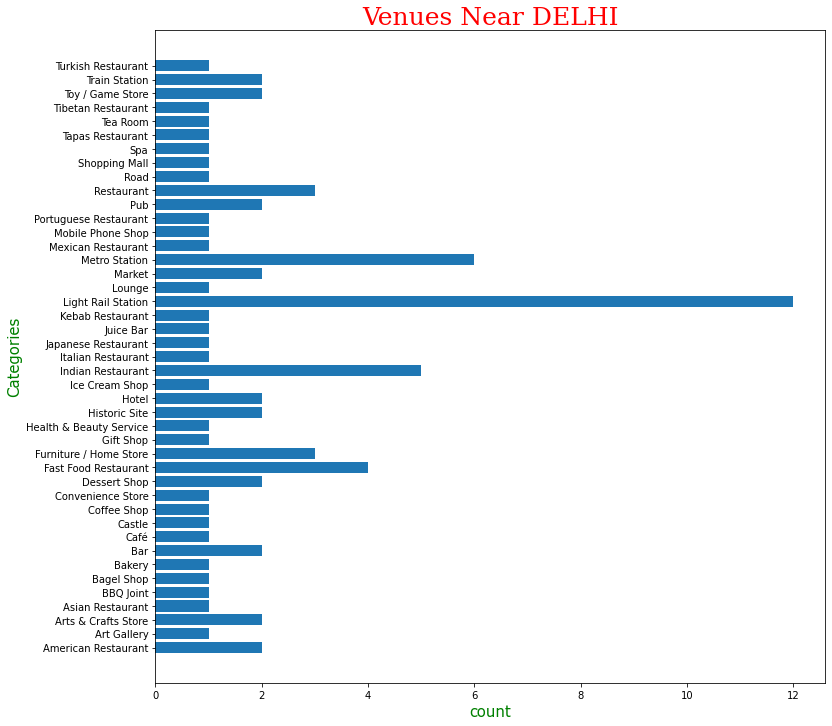

In [250]:
plt.figure(figsize=(12,12))
bar_categories(nearby_delhi,'DELHI')

<BarContainer object of 19 artists>

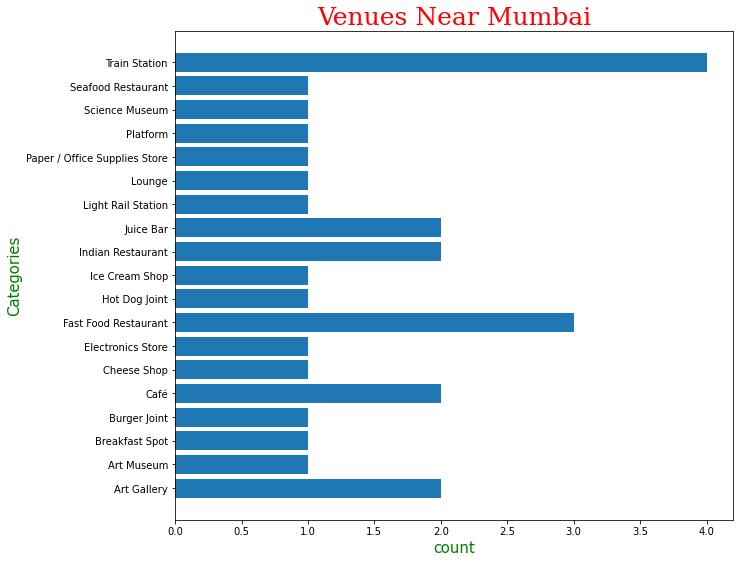

In [251]:
plt.figure(figsize=(10,9))
bar_categories(nearby_mumbai,'Mumbai')

In [354]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

In [355]:
delhi_venue_onehot=pd.get_dummies(nearby_delhi['Categories'],prefix='',prefix_sep='')
delhi_venue_onehot['Neighborhood']=nearby_delhi['Neighborhood']
fixed=[delhi_venue_onehot.columns[-1]]+list(delhi_venue_onehot.columns[:-1])
delhi_venue_onehot=delhi_venue_onehot[fixed]
delhi_grouped=delhi_venue_onehot.groupby('Neighborhood',as_index=False).mean()
num_top_venues = 1
columns = ['Neighborhood','Most Visited place']

delhi_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
delhi_neighborhoods_venues_sorted['Neighborhood'] = delhi_grouped['Neighborhood']

for ind in np.arange(delhi_grouped.shape[0]):
    delhi_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)


delhi_neighborhoods_venues_sorted.head()

Neighborhood      Most Visited place
0   Adarsh Nagar      Light Rail Station
1       Badarpur           Train Station
2  Chandni Chowk           Historic Site
3     Chattarpur  Furniture / Home Store
4    Civil Lines      Italian Restaurant

In [356]:
mumbai_venue_onehot=pd.get_dummies(nearby_mumbai['Categories'],prefix='',prefix_sep='')
mumbai_venue_onehot['Neighborhood']=nearby_mumbai['Neighborhood']
fixed=[mumbai_venue_onehot.columns[-1]]+list(mumbai_venue_onehot.columns[:-1])
mumbai_venue_onehot=mumbai_venue_onehot[fixed]
mumbai_grouped=mumbai_venue_onehot.groupby('Neighborhood',as_index=False).mean()
num_top_venues = 1
columns = ['Neighborhood','Most Visited place']

mumbai_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
mumbai_neighborhoods_venues_sorted['Neighborhood'] = mumbai_grouped['Neighborhood']

for ind in np.arange(mumbai_grouped.shape[0]):
    mumbai_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mumbai_grouped.iloc[ind, :], num_top_venues)


mumbai_neighborhoods_venues_sorted.head()

Neighborhood    Most Visited place
0      Andheri  Fast Food Restaurant
1       Bandra         Train Station
2      Byculla           Art Gallery
3       Colaba           Art Gallery
4        Dadar        Breakfast Spot

In [357]:
mumbai_grouped

Neighborhood  Art Gallery  Art Museum  Breakfast Spot  Burger Joint  Café  \
0       Andheri          0.0         0.0             0.0          0.25   0.0   
1        Bandra          0.0         0.0             0.0          0.00   0.0   
2       Byculla          1.0         0.0             0.0          0.00   0.0   
3        Colaba          1.0         0.0             0.0          0.00   0.0   
4         Dadar          0.0         0.0             1.0          0.00   0.0   
5       Dahisar          0.0         0.0             0.0          0.00   1.0   
6          Fort          0.0         0.0             0.0          0.00   0.0   
7       Girgaon          0.0         0.0             0.0          0.00   0.0   
8      Goregaon          0.0         0.0             0.0          0.00   0.0   
9       Govandi          0.0         0.0             0.0          0.00   0.0   
10         Khar          0.0         1.0             0.0          0.00   0.0   
11        Kurla          0.0         0.0             0.0          0.00   0.0   
12        Malad          0.0         0.0             0.0          0.00   0.0   
13      Matunga          0.0         0.0             0.0          0.00   0.0   
14       Mulund          0.0         0.0             0.0          0.00   0.0   
15    Santacruz          0.0         0.0             0.0          0.00   0.5   
16   Vidyavihar          0.0         0.0             0.0          0.00   0.0   
17     Vikhroli          0.0         0.0             0.0          0.00   0.0   

    Cheese Shop  Electronics Store  Fast Food Restaurant  Hot Dog Joint  \
0           0.0                0.0                  0.50            0.0   
1           0.0                0.0                  0.00            0.0   
2           0.0                0.0                  0.00            0.0   
3           0.0                0.0                  0.00            0.0   
4           0.0                0.0                  0.00            0.0   
5           0.0                0.0                  0.00            0.0   
6           0.0                0.0                  0.00            0.0   
7           0.0                0.0                  0.25            0.0   
8           0.0                0.0                  0.00            0.0   
9           0.0                0.0                  0.00            1.0   
10          0.0                0.0                  0.00            0.0   
11          0.5                0.0                  0.00            0.0   
12          0.0                1.0                  0.00            0.0   
13          0.0                0.0                  0.00            0.0   
14          0.0                0.0                  0.00            0.0   
15          0.0                0.0                  0.00            0.0   
16          0.0                0.0                  0.00            0.0   
17          0.0                0.0                  0.00            0.0   

    Ice Cream Shop  Indian Restaurant  Juice Bar  Light Rail Station  Lounge  \
0             0.00           0.000000        0.0                 0.0     0.0   
1             0.00           0.333333        0.0                 0.0     0.0   
2             0.00           0.000000        0.0                 0.0     0.0   
3             0.00           0.000000        0.0                 0.0     0.0   
4             0.00           0.000000        0.0                 0.0     0.0   
5             0.00           0.000000        0.0                 0.0     0.0   
6             0.00           0.000000        0.0                 0.0     0.0   
7             0.25           0.000000        0.5                 0.0     0.0   
8             0.00           1.000000        0.0                 0.0     0.0   
9             0.00           0.000000        0.0                 0.0     0.0   
10            0.00           0.000000        0.0                 0.0     0.0   
11            0.00           0.000000        0.0                 0.0     0.0   
12            0.

In [358]:
mumbai_needed_columns=list( set(delhi_grouped)-set(mumbai_grouped))
delhi_needed_columns= list(set(mumbai_grouped)-set(delhi_grouped))
mumbai_grouped[mumbai_needed_columns]=0.0
delhi_grouped[delhi_needed_columns]=0.0

In [359]:
mumbai_grouped

Neighborhood  Art Gallery  Art Museum  Breakfast Spot  Burger Joint  Café  \
0       Andheri          0.0         0.0             0.0          0.25   0.0   
1        Bandra          0.0         0.0             0.0          0.00   0.0   
2       Byculla          1.0         0.0             0.0          0.00   0.0   
3        Colaba          1.0         0.0             0.0          0.00   0.0   
4         Dadar          0.0         0.0             1.0          0.00   0.0   
5       Dahisar          0.0         0.0             0.0          0.00   1.0   
6          Fort          0.0         0.0             0.0          0.00   0.0   
7       Girgaon          0.0         0.0             0.0          0.00   0.0   
8      Goregaon          0.0         0.0             0.0          0.00   0.0   
9       Govandi          0.0         0.0             0.0          0.00   0.0   
10         Khar          0.0         1.0             0.0          0.00   0.0   
11        Kurla          0.0         0.0             0.0          0.00   0.0   
12        Malad          0.0         0.0             0.0          0.00   0.0   
13      Matunga          0.0         0.0             0.0          0.00   0.0   
14       Mulund          0.0         0.0             0.0          0.00   0.0   
15    Santacruz          0.0         0.0             0.0          0.00   0.5   
16   Vidyavihar          0.0         0.0             0.0          0.00   0.0   
17     Vikhroli          0.0         0.0             0.0          0.00   0.0   

    Cheese Shop  Electronics Store  Fast Food Restaurant  Hot Dog Joint  ...  \
0           0.0                0.0                  0.50            0.0  ...   
1           0.0                0.0                  0.00            0.0  ...   
2           0.0                0.0                  0.00            0.0  ...   
3           0.0                0.0                  0.00            0.0  ...   
4           0.0                0.0                  0.00            0.0  ...   
5           0.0                0.0                  0.00            0.0  ...   
6           0.0                0.0                  0.00            0.0  ...   
7           0.0                0.0                  0.25            0.0  ...   
8           0.0                0.0                  0.00            0.0  ...   
9           0.0                0.0                  0.00            1.0  ...   
10          0.0                0.0                  0.00            0.0  ...   
11          0.5                0.0                  0.00            0.0  ...   
12          0.0                1.0                  0.00            0.0  ...   
13          0.0                0.0                  0.00            0.0  ...   
14          0.0                0.0                  0.00            0.0  ...   
15          0.0                0.0                  0.00            0.0  ...   
16          0.0                0.0                  0.00            0.0  ...   
17          0.0                0.0                  0.00            0.0  ...   

    Kebab Restaurant  Mexican Restaurant  Toy / Game Store  \
0                0.0                 0.0               0.0   
1                0.0                 0.0               0.0   
2                0.0                 0.0               0.0   
3                0.0                 0.0               0.0   
4                0.0                 0.0               0.0   
5                0.0                 0.0               0.0   
6                0.0                 0.0               0.0   
7                0.0                 0.0               0.0   
8                0.0                 0.0               0.0   
9                0.0                 0.0               0.0   
10               0.0                 0.0               0.0   
11               0.0                 0.0               0.0   
12               0.0                 0.0               0.0   
13               0.0                 0.0               0.0   
14               0.0           

####  Modelling

In [378]:
cost=[]
X=delhi_grouped.drop('Neighborhood',axis=1)
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,n_init=1)
    kmeans.fit(X)
    cost.append(kmeans.inertia_)
print(cost)
plt.plot(list(range(1,11)),cost)

[24.926501271646334, 20.057259376511457, 17.579242615961604, 16.27746929125046, 14.577309941520467, 12.556858520570428, 12.441678318603529, 10.929219397823767, 10.424727608494923, 9.939542936288092]


In [379]:
k_cluster=6
kmeans=KMeans(n_clusters=k_cluster,n_init=14,random_state=6)
kmeans.fit(X)

KMeans(n_clusters=6, n_init=14, random_state=6)

In [380]:
labels=kmeans.labels_
labels

array([1, 2, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 5, 1, 3, 3, 5, 1, 3, 5, 3,
       4, 3, 3, 3, 1, 1, 3, 3, 2, 1, 1, 5, 4, 1, 1, 3])

In [381]:
delhi_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [382]:
delhi_merged=pd.merge(delhi_neighborhoods_venues_sorted,delhi_dataframe,left_on='Neighborhood',right_on='Neighborhood')
delhi_merged

Cluster Labels        Neighborhood       Most Visited place Latitude  \
0                1        Adarsh Nagar       Light Rail Station  28.7166   
1                2            Badarpur            Train Station  28.4932   
2                0       Chandni Chowk            Historic Site  28.6561   
3                3          Chattarpur   Furniture / Home Store  28.4971   
4                3         Civil Lines       Italian Restaurant  28.6769   
5                3     Connaught Place    Portuguese Restaurant  28.6314   
6                1         Dhaula Kuan       Light Rail Station  28.5919   
7                3      Dilshad Garden        Indian Restaurant  28.6758   
8                3     Dwarka Sub City         Toy / Game Store  28.5679   
9                3         Gole Market         Kebab Restaurant  28.6337   
10               3          Green Park      Japanese Restaurant   28.558   
11               3   Hauz Khas Village      American Restaurant  28.5539   
12               3          INA Colony        Indian Restaurant  28.5744   
13               5            Jangpura            Metro Station   28.583   
14               1         Jhandewalan       Light Rail Station  28.6443   
15               3      Jhilmil Colony                Juice Bar  28.6698   
16               3          Karol Bagh  Health & Beauty Service   28.653   
17               5         Kirti Nagar            Metro Station  28.6545   
18               1         Laxmi Nagar       Light Rail Station  28.6306   
19               3          Mahipalpur                    Hotel  28.5445   
20               5          Moti Nagar           Ice Cream Shop  28.6579   
21               3  New Friends Colony             Dessert Shop  28.5671   
22               4               Okhla      Arts & Crafts Store  28.5637   
23               3           Paharganj                    Hotel  28.6415   
24               3        Pandav Nagar        Mobile Phone Shop   28.618   
25               3          Pitam Pura        Indian Restaurant  28.7033   
26               1      Pragati Maidan       Light Rail Station  28.6235   
27               1         Preet Vihar       Light Rail Station  28.6414   
28               3     Rohini Sub City         Toy / Game Store  28.5679   
29               3        Sadar Bazaar     Fast Food Restaurant  28.6609   
30               2        Sarita Vihar            Train Station  28.5286   
31               1            Shahdara       Light Rail Station  28.6733   
32               1       Shastri Nagar       Light Rail Station  28.6701   
33               5        Shastri Park            Metro Station  28.6684   
34               4     South Extension      Arts & Crafts Store  28.5686   
35               1         Tilak Nagar       Light Rail Station  28.6365   
36               1          Tis Hazari       Light Rail Station  28.6672   
37               3         Tughlaqabad                   Castle  28.5112   

   Longitude  Importance  
0    77.1704    0.708428  
1     77.303    0.559806  
2    77.2354    0.311000  
3    77.1813    0.345000  
4     77.225    0.672086  
5    77.2198    0.739507  
6    77.1617    0.649056  
7    77.3215    0.661947  
8    77.1594    0.211000  
9    77.2056    0.614123  
10   77.2068    0.649557  
11   77.1947    0.610000  
12   77.2102    0.510000  
13   77.2393    0.221000  
14   77.1999    0.589576  
15   77.3073    0.435000  
16    77.189    0.722982  
17   77.1514    0.676913  
18   77.2776    0.651521  
19   77.1279    0.495000  
20   77.1424    0.713050  
21   77.2698    0.660000  
22   77.2891    0.533561  
23   77.2141    0.495000  
24   77.2867    0.311000  
25   77.1322    0.655499  
26   77.2425    0.659872  
27   77.2953    0.659235  
28   77.1594    0.211000  
29   77.2277    0.560502  
30   77.2883    0.649806  
31    77.289    0.567286  
32   77.1819    0.655951  
33   77.2505    0.655951  
34   77.2206    0.650301  
35   77.0965    0.682128  
36   77.2166    0.671390  
37   77.2623 

In [383]:
labels=kmeans.labels_
labels

array([1, 2, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 5, 1, 3, 3, 5, 1, 3, 5, 3,
       4, 3, 3, 3, 1, 1, 3, 3, 2, 1, 1, 5, 4, 1, 1, 3])

In [385]:
address='{}'.format('Delhi')
geolocator=geopy.geocoders.Nominatim(user_agent='neighod')
g=geolocator.geocode(address)
lat=g.latitude
lng=g.longitude
map_delhi_cluster=folium.Map(location=[lat,lng])

array=plt.cm.rainbow(np.linspace(0,1,k_cluster))
color=[colors.rgb2hex(i) for i in array]
for i,data in delhi_merged.iterrows():
    
    folium.CircleMarker(location=[data['Latitude'],data['Longitude']],
                       radius=2,
                       fill=True,
                       fill_color=color[int(data['Cluster Labels']-1)],
                       fill_opacity=0.7,
                       color=color[int(data['Cluster Labels']-1)]).add_to(map_delhi_cluster)
map_delhi_cluster

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Delhi&format=json&limit=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000284FBA3CA60>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [386]:
delhi_merged[delhi_merged['Cluster Labels']==0]

Cluster Labels   Neighborhood Most Visited place Latitude Longitude  \
2               0  Chandni Chowk      Historic Site  28.6561   77.2354   

   Importance  
2       0.311

In [387]:
delhi_merged[delhi_merged['Cluster Labels']==1]

Cluster Labels    Neighborhood  Most Visited place Latitude Longitude  \
0                1    Adarsh Nagar  Light Rail Station  28.7166   77.1704   
6                1     Dhaula Kuan  Light Rail Station  28.5919   77.1617   
14               1     Jhandewalan  Light Rail Station  28.6443   77.1999   
18               1     Laxmi Nagar  Light Rail Station  28.6306   77.2776   
26               1  Pragati Maidan  Light Rail Station  28.6235   77.2425   
27               1     Preet Vihar  Light Rail Station  28.6414   77.2953   
31               1        Shahdara  Light Rail Station  28.6733    77.289   
32               1   Shastri Nagar  Light Rail Station  28.6701   77.1819   
35               1     Tilak Nagar  Light Rail Station  28.6365   77.0965   
36               1      Tis Hazari  Light Rail Station  28.6672   77.2166   

    Importance  
0     0.708428  
6     0.649056  
14    0.589576  
18    0.651521  
26    0.659872  
27    0.659235  
31    0.567286  
32    0.655951  
35    0.682128  
36    0.671390

In [388]:
delhi_merged[delhi_merged['Cluster Labels']==2]

Cluster Labels  Neighborhood Most Visited place Latitude Longitude  \
1                2      Badarpur      Train Station  28.4932    77.303   
30               2  Sarita Vihar      Train Station  28.5286   77.2883   

    Importance  
1     0.559806  
30    0.649806

In [389]:
delhi_merged[delhi_merged['Cluster Labels']==3]

Cluster Labels        Neighborhood       Most Visited place Latitude  \
3                3          Chattarpur   Furniture / Home Store  28.4971   
4                3         Civil Lines       Italian Restaurant  28.6769   
5                3     Connaught Place    Portuguese Restaurant  28.6314   
7                3      Dilshad Garden        Indian Restaurant  28.6758   
8                3     Dwarka Sub City         Toy / Game Store  28.5679   
9                3         Gole Market         Kebab Restaurant  28.6337   
10               3          Green Park      Japanese Restaurant   28.558   
11               3   Hauz Khas Village      American Restaurant  28.5539   
12               3          INA Colony        Indian Restaurant  28.5744   
15               3      Jhilmil Colony                Juice Bar  28.6698   
16               3          Karol Bagh  Health & Beauty Service   28.653   
19               3          Mahipalpur                    Hotel  28.5445   
21               3  New Friends Colony             Dessert Shop  28.5671   
23               3           Paharganj                    Hotel  28.6415   
24               3        Pandav Nagar        Mobile Phone Shop   28.618   
25               3          Pitam Pura        Indian Restaurant  28.7033   
28               3     Rohini Sub City         Toy / Game Store  28.5679   
29               3        Sadar Bazaar     Fast Food Restaurant  28.6609   
37               3         Tughlaqabad                   Castle  28.5112   

   Longitude  Importance  
3    77.1813    0.345000  
4     77.225    0.672086  
5    77.2198    0.739507  
7    77.3215    0.661947  
8    77.1594    0.211000  
9    77.2056    0.614123  
10   77.2068    0.649557  
11   77.1947    0.610000  
12   77.2102    0.510000  
15   77.3073    0.435000  
16    77.189    0.722982  
19   77.1279    0.495000  
21   77.2698    0.660000  
23   77.2141    0.495000  
24   77.2867    0.311000  
25   77.1322    0.655499  
28   77.1594    0.211000  
29   77.2277    0.560502  
37   77.2623    0.285000

In [390]:
delhi_merged[delhi_merged['Cluster Labels']==4]

Cluster Labels     Neighborhood   Most Visited place Latitude Longitude  \
22               4            Okhla  Arts & Crafts Store  28.5637   77.2891   
34               4  South Extension  Arts & Crafts Store  28.5686   77.2206   

    Importance  
22    0.533561  
34    0.650301

In [391]:
delhi_merged[delhi_merged['Cluster Labels']==5]

Cluster Labels  Neighborhood Most Visited place Latitude Longitude  \
13               5      Jangpura      Metro Station   28.583   77.2393   
17               5   Kirti Nagar      Metro Station  28.6545   77.1514   
20               5    Moti Nagar     Ice Cream Shop  28.6579   77.1424   
33               5  Shastri Park      Metro Station  28.6684   77.2505   

    Importance  
13    0.221000  
17    0.676913  
20    0.713050  
33    0.655951

In [393]:
delhi_merged[delhi_merged['Cluster Labels']==-1]

Empty DataFrame
Columns: [Cluster Labels, Neighborhood, Most Visited place, Latitude, Longitude, Importance]
Index: []

In [394]:
x_predict=mumbai_grouped.drop('Neighborhood',axis=1)

In [395]:
kmeans.predict(x_predict)

array([3, 3, 3, 3, 4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [351]:
mumbai_needed_columns= set(delhi_grouped)-set(mumbai_grouped)
delhi_needed_columns= set(mumbai_grouped)-set(delhi_grouped)

In [352]:
len(delhi_needed_columns)

10

In [353]:
mumbai_grouped

Neighborhood  Art Gallery  Art Museum  Breakfast Spot  Burger Joint  Café  \
0       Andheri          0.0         0.0             0.0          0.25   0.0   
1        Bandra          0.0         0.0             0.0          0.00   0.0   
2       Byculla          1.0         0.0             0.0          0.00   0.0   
3        Colaba          1.0         0.0             0.0          0.00   0.0   
4         Dadar          0.0         0.0             1.0          0.00   0.0   
5       Dahisar          0.0         0.0             0.0          0.00   1.0   
6          Fort          0.0         0.0             0.0          0.00   0.0   
7       Girgaon          0.0         0.0             0.0          0.00   0.0   
8      Goregaon          0.0         0.0             0.0          0.00   0.0   
9       Govandi          0.0         0.0             0.0          0.00   0.0   
10         Khar          0.0         1.0             0.0          0.00   0.0   
11        Kurla          0.0         0.0             0.0          0.00   0.0   
12        Malad          0.0         0.0             0.0          0.00   0.0   
13      Matunga          0.0         0.0             0.0          0.00   0.0   
14       Mulund          0.0         0.0             0.0          0.00   0.0   
15    Santacruz          0.0         0.0             0.0          0.00   0.5   
16   Vidyavihar          0.0         0.0             0.0          0.00   0.0   
17     Vikhroli          0.0         0.0             0.0          0.00   0.0   

    Cheese Shop  Electronics Store  Fast Food Restaurant  Hot Dog Joint  \
0           0.0                0.0                  0.50            0.0   
1           0.0                0.0                  0.00            0.0   
2           0.0                0.0                  0.00            0.0   
3           0.0                0.0                  0.00            0.0   
4           0.0                0.0                  0.00            0.0   
5           0.0                0.0                  0.00            0.0   
6           0.0                0.0                  0.00            0.0   
7           0.0                0.0                  0.25            0.0   
8           0.0                0.0                  0.00            0.0   
9           0.0                0.0                  0.00            1.0   
10          0.0                0.0                  0.00            0.0   
11          0.5                0.0                  0.00            0.0   
12          0.0                1.0                  0.00            0.0   
13          0.0                0.0                  0.00            0.0   
14          0.0                0.0                  0.00            0.0   
15          0.0                0.0                  0.00            0.0   
16          0.0                0.0                  0.00            0.0   
17          0.0                0.0                  0.00            0.0   

    Ice Cream Shop  Indian Restaurant  Juice Bar  Light Rail Station  Lounge  \
0             0.00           0.000000        0.0                 0.0     0.0   
1             0.00           0.333333        0.0                 0.0     0.0   
2             0.00           0.000000        0.0                 0.0     0.0   
3             0.00           0.000000        0.0                 0.0     0.0   
4             0.00           0.000000        0.0                 0.0     0.0   
5             0.00           0.000000        0.0                 0.0     0.0   
6             0.00           0.000000        0.0                 0.0     0.0   
7             0.25           0.000000        0.5                 0.0     0.0   
8             0.00           1.000000        0.0                 0.0     0.0   
9             0.00           0.000000        0.0                 0.0     0.0   
10            0.00           0.000000        0.0                 0.0     0.0   
11            0.00           0.000000        0.0                 0.0     0.0   
12            0.